# Initial conditions

In [ ]:
# Distribution choice (triangular or uniform or normal)?
distribution_choice = 'triangular'
beta_e = 0.9
beta_p = 0.8
gamma = 0.97
R = 1.05
y_lower = 800
y_upper = 4800
y_3 = 1300
y_1 = 1100
y_mode = 2800 # triangular
y_mean = 1300
sigma = 100000 # normal

In [ ]:
distribution_choice = 'uniform'
beta_e = 0.7
beta_p = 0.8
gamma = 0.95
R = 1.18
y_lower = 8300
y_upper = 14000
y_3 = 5200
y_1 = 9600
y_mode = 28000 # triangular
y_mean = 28000 # normal
sigma = 1000000 # normal

# Different distributions, PDF, and CDF

In [ ]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import fsolve
import pandas as pd
from google.colab import files

In [ ]:
sigma = np.sqrt(sigma) # normal
psi = np.log(y_3) - np.log(gamma * y_3)

b_upper_e = (1 - gamma * np.exp(- beta_e * psi)) * y_upper
b_lower_e = (1 - gamma * np.exp(- beta_e * psi)) * y_lower
b_upper_p = (1 - gamma * np.exp(- beta_p * psi)) * y_upper
b_lower_p = (1 - gamma * np.exp(- beta_p * psi)) * y_lower

print(f"debt level where default starts for E type = {b_lower_e:.3f}")
print(f"debt level with always default for E type = {b_upper_e:.3f}")
print(f"debt level where default starts for P type = {b_lower_p:.3f}")
print(f"debt level with always default for P type = {b_upper_p:.3f}")

debt level where default starts for E type = 44.984
debt level with always default for E type = 269.903
debt level where default starts for P type = 42.681
debt level with always default for P type = 256.083


In [ ]:
uniform_pdf = lambda y: 1 / (y_upper - y_lower) if y_lower <= y <= y_upper else 0

def normal_pdf(y):
    normalization_constant = norm.cdf(y_upper, y_mean, sigma) - norm.cdf(y_lower, y_mean, sigma)

    if y_lower <= y <= y_upper:
        pdf_at_y = norm.pdf(y, y_mean, sigma)
        truncated_pdf = pdf_at_y / normalization_constant
        return truncated_pdf
    else:
        return 0

def triangular_pdf(y):
    if y_lower <= y <= y_mode:
        return 2 * (y - y_lower) / ((y_upper - y_lower) * (y_mode - y_lower))
    elif y_mode < y <= y_upper:
        return 2 * (y_upper - y) / ((y_upper - y_lower) * (y_upper - y_mode))
    else:
        return 0

In [ ]:
c = 0.001
def modify_triangular_pdf(y):
    # Original triangular PDF without the shift
    if y_lower <= y <= y_mode:
        original_pdf = 2 * (y - y_lower) / ((y_upper - y_lower) * (y_mode - y_lower))
    elif y_mode < y <= y_upper:
        original_pdf = 2 * (y_upper - y) / ((y_upper - y_lower) * (y_upper - y_mode))
    else:
        original_pdf = 0

    # Total width of the distribution
    width = y_upper - y_lower

    # Adjustment needed to maintain total area = 1
    # Total area is the area under the original PDF plus the area added by the constant c
    area_under_original_pdf = 1  # By definition of PDF
    area_added_by_c = c * width
    total_area = area_under_original_pdf + area_added_by_c

    # Normalization factor to adjust the PDF so that the total area remains 1
    normalization_factor = 1 / total_area

    # Shifted and normalized PDF
    shifted_pdf = (original_pdf + c) * normalization_factor

    return shifted_pdf

In [ ]:
def normal_cdf(y):
    cdf_at_y = norm.cdf(y, y_mean, sigma)
    cdf_at_y_lower = norm.cdf(y_lower, y_mean, sigma)
    cdf_at_y_upper = norm.cdf(y_upper, y_mean, sigma)
    if y < y_lower:
        return 0
    elif y > y_upper:
        return 1
    else:
        return (cdf_at_y - cdf_at_y_lower) / (cdf_at_y_upper - cdf_at_y_lower)

def uniform_cdf(y):
    if y < y_lower:
        return 0
    elif y_lower <= y <= y_upper:
        return (y - y_lower) / (y_upper - y_lower)
    else:
        return 1

def triangular_cdf(y):
    if y < y_lower:
        return 0
    elif y_lower <= y < y_mode:
        return ((y - y_lower)**2) / ((y_upper - y_lower) * (y_mode - y_lower))
    elif y_mode <= y <= y_upper:
        return 1 - ((y_upper - y)**2) / ((y_upper - y_lower) * (y_upper - y_mode))
    else:
        return 1

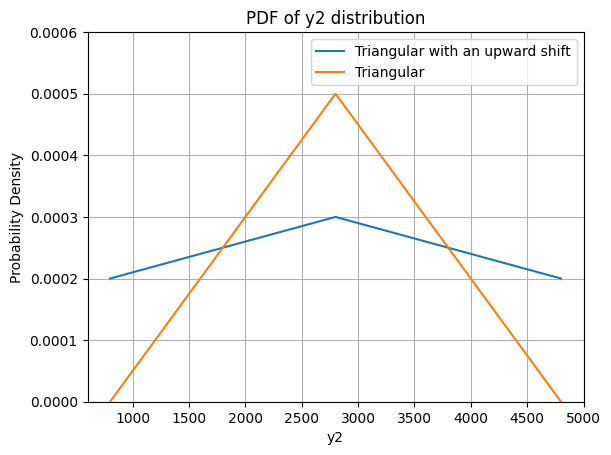

In [ ]:
y_values = np.linspace(y_lower - 0.1, y_upper + 0.1, 1000)
pdf_values_triangular = [triangular_pdf(y) for y in y_values]
pdf_values_triangular_modify = [modify_triangular_pdf(y) for y in y_values]
pdf_values_uniform = [uniform_pdf(y) for y in y_values]
pdf_values_normal = [normal_pdf(y) for y in y_values]

plt.plot(y_values, pdf_values_triangular_modify, label='Triangular with an upward shift')
plt.plot(y_values, pdf_values_triangular, label='Triangular')
#plt.plot(y_values, pdf_values_uniform, label='Uniform')
#plt.plot(y_values, pdf_values_normal, label='Normal')
plt.title('PDF of y2 distribution')
plt.xlabel('y2')
plt.ylim(0,0.0006)
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
#plt.savefig('pdf.png')
plt.show()
#files.download('pdf.png')

In [ ]:
if distribution_choice == 'triangular':
    chosen_cdf = triangular_cdf
    chosen_pdf = triangular_pdf
elif distribution_choice == 'uniform':
    chosen_cdf = uniform_cdf
    chosen_pdf = uniform_pdf
elif distribution_choice == 'normal':
    chosen_cdf = normal_cdf
    chosen_pdf = normal_pdf

# Calculating $b^E$

In [ ]:
# def Total_U_e(b, gamma, beta_e, beta_p, psi, R, y_1, y_3, y_lower, y_upper, cdf, pdf):
#     y_tau = b / (1 - gamma * np.exp(-beta_e * psi))
#     cdf = cdf(y_tau)
#     q_e = (1 / R) * (1 - cdf)
#     integral_case_1, _ = quad(lambda y_2: np.log(y_2 - b) * pdf(y_2), y_lower, y_upper)
#     def integrand_case_2_1(y_2):
#         return np.log(y_2 - b) * pdf(y_2)
#     def integrand_case_2_2(y_2):
#         return np.log(gamma * y_2) * pdf(y_2)
#     integral_case_2_1, _ = quad(integrand_case_2_1, y_tau, y_upper)
#     integral_case_2_2, _ = quad(integrand_case_2_2, y_lower, y_tau)
#     integral_case_3, _ = quad(lambda y_2: np.log(gamma * y_2) * pdf(y_2), y_lower, y_upper)
#     U_period_1 = np.log(y_1 + q_e * b)
#     U_period_2 = ((1 if y_lower < y_tau < y_upper else 0) *
#                  (beta_e * integral_case_2_1 + beta_e * integral_case_2_2) +
#                  (1 if y_tau < y_lower else 0) * (beta_e * integral_case_1) +
#                  (1 if y_tau > y_upper else 0) * (beta_e * integral_case_3))
#     U_period_3 = ((beta_e ** 2) * np.log(y_3) * (1 - cdf) +
#                   (beta_e ** 2) * np.log(gamma * y_3) * cdf)
#     U_total = U_period_1 + U_period_2 + U_period_3
#     return U_total

In [ ]:
def Total_U_e(b, gamma, beta_e, beta_p, psi, R, y_1, y_3, y_lower, y_upper, cdf, pdf):
    y_tau = b / (1 - gamma * np.exp(-beta_e * psi))
    cdf_value = cdf(y_tau)
    q_e = (1 / R) * (1 - cdf_value)

    # Initialize integral_case_1 to 0 to ensure it has a value even if not calculated
    integral_case_1 = 0

    # Compute integral_case_1 only if b is less than y_lower
    if b < y_lower:
        integral_case_1, _ = quad(lambda y_2: np.log(y_2 - b) * pdf(y_2) if y_2 > b else 0, y_lower, y_upper)

    def integrand_case_2_1(y_2):
        return np.log(y_2 - b) * pdf(y_2) if y_2 > b else 0  # Ensure logarithm is computed for valid values only

    def integrand_case_2_2(y_2):
        return np.log(gamma * y_2) * pdf(y_2)

    integral_case_2_1, _ = quad(integrand_case_2_1, max(y_tau, b), y_upper)  # Ensure y_2 > b
    integral_case_2_2, _ = quad(integrand_case_2_2, y_lower, y_tau)
    integral_case_3, _ = quad(lambda y_2: np.log(gamma * y_2) * pdf(y_2), y_lower, y_upper)

    U_period_1 = np.log(y_1 + q_e * b)
    U_period_2 = ((1 if y_lower < y_tau < y_upper else 0) *
                  (beta_e * integral_case_2_1 + beta_e * integral_case_2_2) +
                  (1 if y_tau <= y_lower else 0) * (beta_e * integral_case_1) +  # Use <= to include equality
                  (1 if y_tau > y_upper else 0) * (beta_e * integral_case_3))
    U_period_3 = ((beta_e ** 2) * np.log(y_3) * (1 - cdf_value) +
                  (beta_e ** 2) * np.log(gamma * y_3) * cdf_value)

    U_total = U_period_1 + U_period_2 + U_period_3
    return U_total

In [ ]:
b_values = np.linspace(0, 1.5 * b_upper_e, 500)
U_values_uniform_e = []
U_values_uniform_p = []

for b in b_values:
    U_uniform_e = Total_U_e(b, gamma, beta_e, beta_p, psi, R, y_1, y_3, y_lower, y_upper, chosen_cdf, chosen_pdf)
    U_values_uniform_e.append(U_uniform_e)

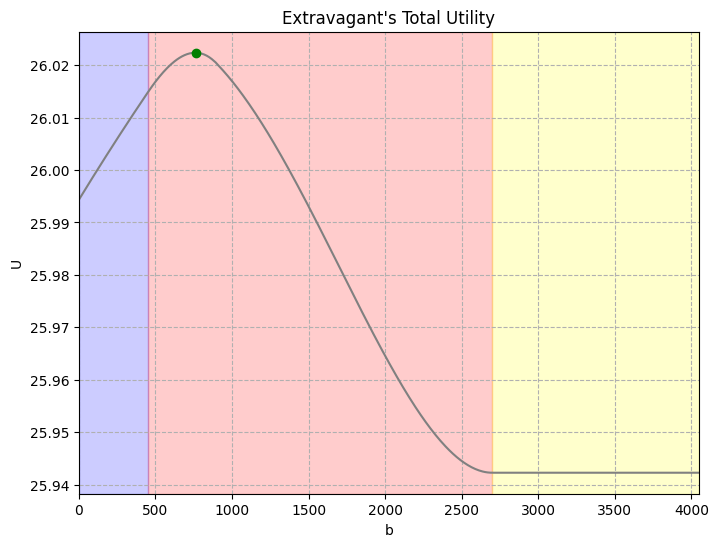

In [ ]:
max_index_uniform_e = np.argmax(U_values_uniform_e)
max_b_uniform_e = b_values[max_index_uniform_e]

plt.figure(figsize=(8, 6))
plt.plot(b_values, U_values_uniform_e, label='Uniform', alpha=1, color='gray')
plt.title('Extravagant\'s Total Utility')
plt.xlabel('b')
plt.ylabel('U')
plt.xlim(0, 1.5*b_upper_e)
plt.grid(True, linestyle='--')
plt.scatter(max_b_uniform_e, U_values_uniform_e[max_index_uniform_e], color='green', zorder=2)
plt.axvspan(0, b_lower_e, color='blue', alpha=0.2)
plt.axvspan(b_lower_e, b_upper_e, color='red', alpha=0.2)
plt.axvspan(b_upper_e, 1.5*b_upper_e, color='yellow', alpha=0.2)
plt.show()

In [ ]:
if max_b_uniform_e > 1.01 * b_lower_e:
    print("b_E in red area")
else:
    print("b_E in blue area")

b_E in red area


# Calculating $\hat{b^E}$

In [ ]:
# def calculate_U_uniform_for_b_hat_e(b, gamma, beta_e, beta_p, psi, R, y_1, y_3, y_lower, y_upper, cdf, pdf):
#     y_tau = b / (1 - gamma * np.exp(-beta_p * psi))
#     cdf_uniform = cdf(y_tau)
#     q_uniform_e = (1 / R) * (1 - cdf_uniform)
#     integral_case_1_uniform, _ = quad(lambda y_2: np.log(y_2 - b) * pdf(y_2), y_lower, y_upper)
#     def integrand_case_2_1_uniform(y_2):
#         return np.log(y_2 - b) * pdf(y_2)
#     def integrand_case_2_2_uniform(y_2):
#         return np.log(gamma * y_2) * pdf(y_2)
#     integral_case_2_1_uniform, _ = quad(integrand_case_2_1_uniform, y_tau, y_upper)
#     integral_case_2_2_uniform, _ = quad(integrand_case_2_2_uniform, y_lower, y_tau)
#     integral_case_3_uniform, _ = quad(lambda y_2: np.log(gamma * y_2) * pdf(y_2), y_lower, y_upper)
#     U_period_1 = np.log(y_1 + q_uniform_e * b)
#     U_period_2 = ((1 if y_lower < y_tau < y_upper else 0) *
#                  (beta_e * integral_case_2_1_uniform + beta_e * integral_case_2_2_uniform) +
#                  (1 if y_tau < y_lower else 0) * (beta_e * integral_case_1_uniform) +
#                  (1 if y_tau > y_upper else 0) * (beta_e * integral_case_3_uniform))
#     U_period_3 = ((beta_e ** 2) * np.log(y_3) * (1 - cdf_uniform) +
#                   (beta_e ** 2) * np.log(gamma * y_3) * cdf_uniform)
#     U_uniform_for_b_hat_e = U_period_1 + U_period_2 + U_period_3
#     return U_uniform_for_b_hat_e

In [ ]:
def calculate_U_uniform_for_b_hat_e(b, gamma, beta_e, beta_p, psi, R, y_1, y_3, y_lower, y_upper, cdf, pdf):
    y_tau = b / (1 - gamma * np.exp(-beta_p * psi))
    cdf_uniform = cdf(y_tau)
    q_uniform_e = (1 / R) * (1 - cdf_uniform)

    # Initialize integral_case_1_uniform to 0 to ensure it has a value even if not calculated
    integral_case_1_uniform = 0

    # Compute integral_case_1_uniform only if b is less than y_lower
    if b < y_lower:
        integral_case_1_uniform, _ = quad(lambda y_2: np.log(y_2 - b) * pdf(y_2) if y_2 > b else 0, y_lower, y_upper)

    def integrand_case_2_1_uniform(y_2):
        return np.log(y_2 - b) * pdf(y_2) if y_2 > b else 0  # Ensure logarithm is computed for valid values only

    def integrand_case_2_2_uniform(y_2):
        return np.log(gamma * y_2) * pdf(y_2)

    integral_case_2_1_uniform, _ = quad(integrand_case_2_1_uniform, max(y_tau, b), y_upper)  # Ensure y_2 > b
    integral_case_2_2_uniform, _ = quad(integrand_case_2_2_uniform, y_lower, y_tau)
    integral_case_3_uniform, _ = quad(lambda y_2: np.log(gamma * y_2) * pdf(y_2), y_lower, y_upper)

    U_period_1 = np.log(y_1 + q_uniform_e * b)
    U_period_2 = ((1 if y_lower < y_tau < y_upper else 0) *
                  (beta_e * integral_case_2_1_uniform + beta_e * integral_case_2_2_uniform) +
                  (1 if y_tau <= y_lower else 0) * (beta_e * integral_case_1_uniform) +  # Use <= to include equality
                  (1 if y_tau > y_upper else 0) * (beta_e * integral_case_3_uniform))
    U_period_3 = ((beta_e ** 2) * np.log(y_3) * (1 - cdf_uniform) +
                  (beta_e ** 2) * np.log(gamma * y_3) * cdf_uniform)

    U_uniform_for_b_hat_e = U_period_1 + U_period_2 + U_period_3
    return U_uniform_for_b_hat_e

In [ ]:
b_values = np.linspace(0, 1.5 * b_upper_e, 500)
U_values_uniform_for_b_hat_e = []

for b in b_values:
    U_uniform_for_b_hat_e = calculate_U_uniform_for_b_hat_e(b, gamma, beta_e, beta_p, psi, R, y_1, y_3, y_lower, y_upper, chosen_cdf, chosen_pdf)
    U_values_uniform_for_b_hat_e.append(U_uniform_for_b_hat_e)

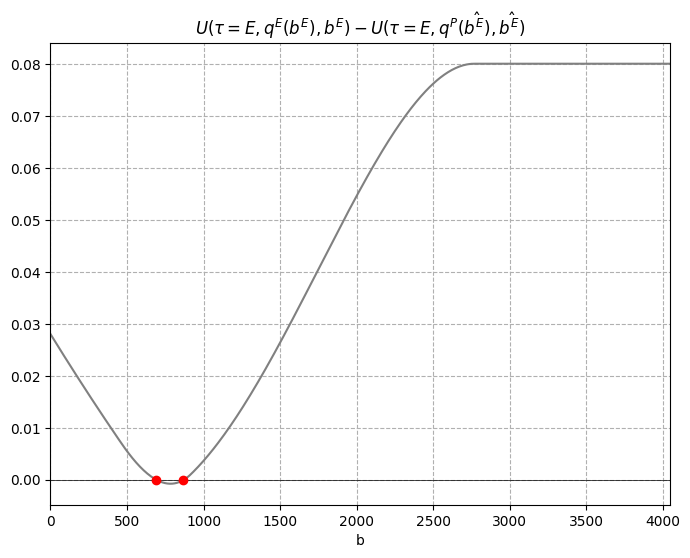

In [ ]:
difference = np.array(U_values_uniform_e)[max_index_uniform_e] - np.array(U_values_uniform_for_b_hat_e)
crossings = np.where(np.diff(np.sign(difference)))[0]
regions = zip([0] + list(crossings), list(crossings) + [len(difference) - 1])
nearest_zero_indices = [np.argmin(np.abs(difference[start:end+1])) + start for start, end in regions]
nearest_zero_indices = list(set(nearest_zero_indices))
b_nearest_zeros = b_values[nearest_zero_indices]
differences_nearest_zeros = difference[nearest_zero_indices]

plt.figure(figsize=(8, 6))
plt.plot(b_values, difference, label='Uniform', alpha=1, color='gray')
plt.scatter(b_nearest_zeros, differences_nearest_zeros, color='red', zorder=5, label='Nearest to 0')  # Mark the nearest points to 0
plt.axhline(0, color='black', linewidth=0.5)  # Zero line for reference
plt.title('$U(τ = E, q^{E}(b^E), b^E) - U(τ = E, q^{P}(\hat{b^E}), \hat{b^E})$')
plt.xlabel('b')
#plt.ylabel('U')
#plt.legend(loc='center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.xlim(0, 1.5 * b_upper_e)
plt.grid(True, linestyle='--')
plt.show()

In [ ]:
threshold = 0.01 * b_upper_e
b_nearest_zeros_sorted = np.sort(b_nearest_zeros)
grouped_b_values = [b_nearest_zeros_sorted[0]]
for b in b_nearest_zeros_sorted[1:]:
    if b - grouped_b_values[-1] > threshold:
        grouped_b_values.append(b)
    else:
        grouped_b_values[-1] = (grouped_b_values[-1] + b) / 2

print('b_hat_e:')
for b_val in grouped_b_values:
    print(b_val)

b_hat_e:
689.6310847909402
868.1238361485954


# Calculating $b^P$

In [ ]:
# def Total_U_p(b, gamma, beta_e, beta_p, psi, R, y_1, y_3, y_lower, y_upper, cdf, pdf):
#     y_tau = b / (1 - gamma * np.exp(-beta_p * psi))
#     cdf = cdf(y_tau)
#     q_p = (1 / R) * (1 - cdf)
#     integral_case_1, _ = quad(lambda y_2: np.log(y_2 - b) * pdf(y_2), y_lower, y_upper)
#     def integrand_case_2_1(y_2):
#         return np.log(y_2 - b) * pdf(y_2)
#     def integrand_case_2_2(y_2):
#         return np.log(gamma * y_2) * pdf(y_2)
#     integral_case_2_1, _ = quad(integrand_case_2_1, y_tau, y_upper)
#     integral_case_2_2, _ = quad(integrand_case_2_2, y_lower, y_tau)
#     integral_case_3, _ = quad(lambda y_2: np.log(gamma * y_2) * pdf(y_2), y_lower, y_upper)
#     U_period_1 = np.log(y_1 + q_p * b)
#     U_period_2 = ((1 if y_lower < y_tau < y_upper else 0) *
#                  (beta_p * integral_case_2_1 + beta_p * integral_case_2_2) +
#                  (1 if y_tau < y_lower else 0) * (beta_p * integral_case_1) +
#                  (1 if y_tau > y_upper else 0) * (beta_p * integral_case_3))
#     U_period_3 = ((beta_p ** 2) * np.log(y_3) * (1 - cdf) +
#                   (beta_p ** 2) * np.log(gamma * y_3) * cdf)
#     U_total = U_period_1 + U_period_2 + U_period_3
#     return U_total

In [ ]:
def Total_U_p(b, gamma, beta_e, beta_p, psi, R, y_1, y_3, y_lower, y_upper, cdf, pdf):
    y_tau = b / (1 - gamma * np.exp(-beta_p * psi))
    cdf_value = cdf(y_tau)
    q_p = (1 / R) * (1 - cdf_value)
    integral_case_1 = 0
    if b < y_lower:
        integral_case_1, _ = quad(lambda y_2: np.log(y_2 - b) * pdf(y_2), y_lower, y_upper)
    def integrand_case_2_1(y_2):
        return np.log(y_2 - b) * pdf(y_2) if y_2 > b else 0  # Add conditional to handle y_2 <= b
    def integrand_case_2_2(y_2):
        return np.log(gamma * y_2) * pdf(y_2)
    integral_case_2_1, _ = quad(integrand_case_2_1, max(y_tau, b), y_upper)  # Ensure y_2 > b
    integral_case_2_2, _ = quad(integrand_case_2_2, y_lower, y_tau)
    integral_case_3, _ = quad(lambda y_2: np.log(gamma * y_2) * pdf(y_2), y_lower, y_upper)
    U_period_1 = np.log(y_1 + q_p * b)
    U_period_2 = ((1 if y_lower < y_tau < y_upper else 0) *
                  (beta_p * integral_case_2_1 + beta_p * integral_case_2_2) +
                  (1 if y_tau <= y_lower else 0) * (beta_p * integral_case_1) +  # Use <= to include equality
                  (1 if y_tau > y_upper else 0) * (beta_p * integral_case_3))
    U_period_3 = ((beta_p ** 2) * np.log(y_3) * (1 - cdf_value) +
                  (beta_p ** 2) * np.log(gamma * y_3) * cdf_value)
    U_total = U_period_1 + U_period_2 + U_period_3
    return U_total

In [ ]:
b_values = np.linspace(0, 1.5 * b_upper_p, 500)
U_values_uniform_p = []

for b in b_values:
    U_uniform_p = Total_U_p(b, gamma, beta_e, beta_p, psi, R, y_1, y_3, y_lower, y_upper, chosen_cdf, chosen_pdf)
    U_values_uniform_p.append(U_uniform_p)

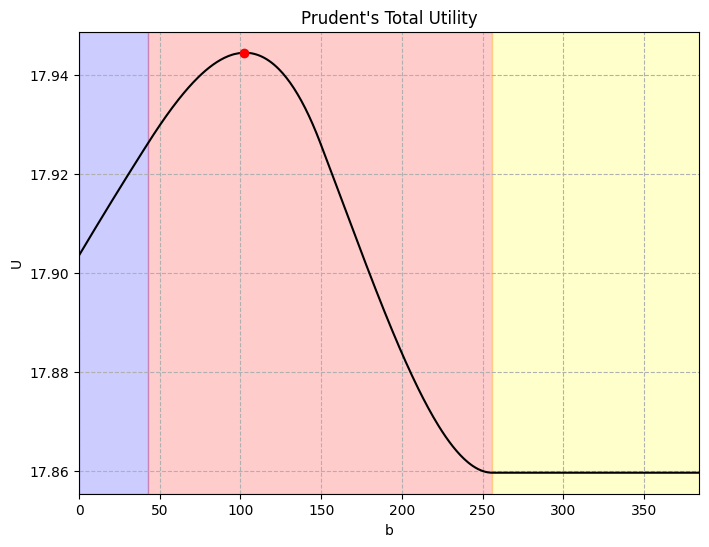

In [ ]:
max_index_uniform_p = np.argmax(U_values_uniform_p)
max_b_uniform_p = b_values[max_index_uniform_p]

plt.figure(figsize=(8, 6))
plt.plot(b_values, U_values_uniform_p, alpha=1, color='black')
plt.title('Prudent\'s Total Utility')
plt.xlabel('b')
plt.ylabel('U')
#plt.xlim(100, 110)
plt.xlim(0, 1.5*b_upper_p)
plt.grid(True, linestyle='--')
plt.scatter(max_b_uniform_p, U_values_uniform_p[max_index_uniform_p], color='red', zorder=2)
plt.axvspan(0, b_lower_p, color='blue', alpha=0.2)
plt.axvspan(b_lower_p, b_upper_p, color='red', alpha=0.2)
plt.axvspan(b_upper_p, 1.5*b_upper_p, color='yellow', alpha=0.2)
plt.show()

In [ ]:
if max_b_uniform_p > 1.01 * b_lower_p:
    print("b_P in red area")
else:
    print("b_P in blue area")

b_P in red area


# Calculating $b^{P*}$

Overall minimum value: 689.6310847909402


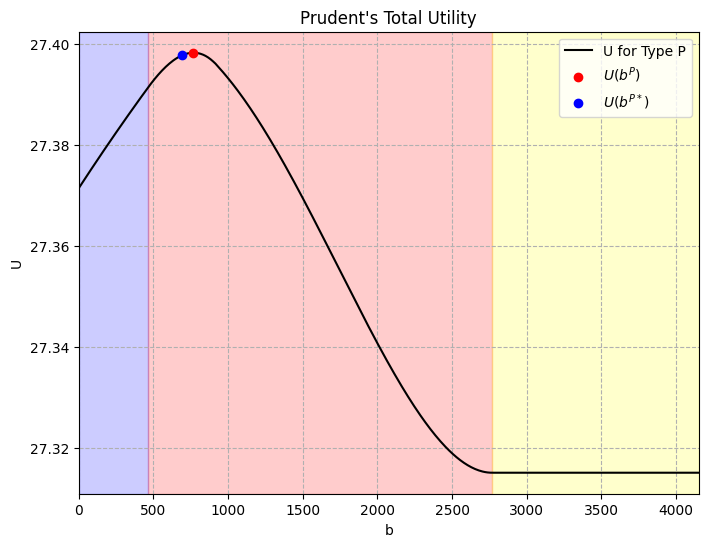

In [ ]:
min_values = [min(b_val, max_b_uniform_p) for b_val in grouped_b_values]
overall_min_value = min(min_values)
print("Overall minimum value:", overall_min_value)

plt.figure(figsize=(8, 6))
plt.plot(b_values, U_values_uniform_p, label='U for Type P', alpha=1, color='black')
plt.title('Prudent\'s Total Utility')
plt.xlabel('b')
plt.ylabel('U')
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.xlim(0, 1.5 * b_upper_p)
plt.grid(True, linestyle='--')
plt.scatter(max_b_uniform_p, U_values_uniform_p[max_index_uniform_p], color='red', zorder=2, label='$U(b^P)$')
plt.axvspan(0, b_lower_p, color='blue', alpha=0.2)
plt.axvspan(b_lower_p, b_upper_p, color='red', alpha=0.2)
plt.axvspan(b_upper_p, 1.5 * b_upper_p, color='yellow', alpha=0.2)

min_value_index = np.argmin(np.abs(b_values - overall_min_value))
U_at_min_value = U_values_uniform_p[min_value_index]

plt.scatter(overall_min_value, U_at_min_value, color='blue', zorder=3, label='$U(b^{P*})$')
plt.legend()
plt.show()

# Checking whether $U^P(b^{P*_{lower}})$ > $U^P(b^{P*_{upper}})$

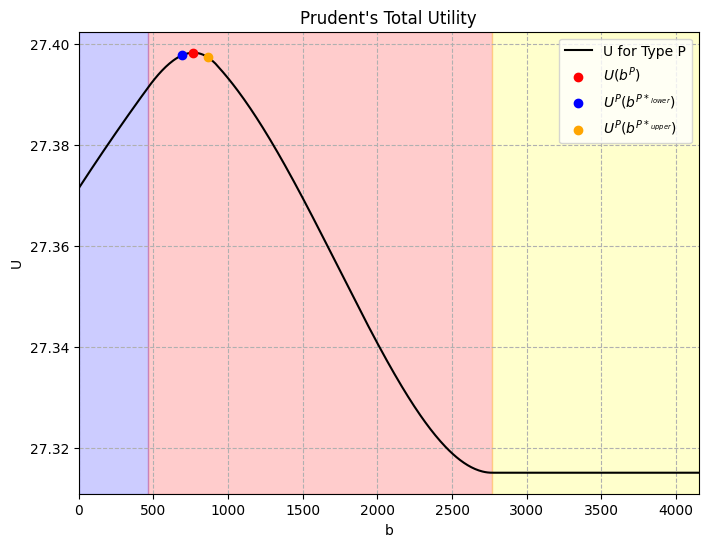

In [ ]:
overall_max_value2 = min(grouped_b_values)
overall_max_value = max(grouped_b_values)

min_value_index2 = np.argmin(np.abs(b_values - overall_max_value2))
U_at_min_value2 = U_values_uniform_p[min_value_index2]

max_value_index = np.argmin(np.abs(b_values - overall_max_value))
U_at_max_value = U_values_uniform_p[max_value_index]

plt.figure(figsize=(8, 6))
plt.plot(b_values, U_values_uniform_p, label='U for Type P', alpha=1, color='black')
plt.title('Prudent\'s Total Utility')
plt.xlabel('b')
plt.ylabel('U')
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.xlim(0, 1.5 * b_upper_p)
plt.grid(True, linestyle='--')
plt.scatter(max_b_uniform_p, U_values_uniform_p[max_index_uniform_p], color='red', zorder=2, label='$U(b^P)$')
plt.axvspan(0, b_lower_p, color='blue', alpha=0.2)
plt.axvspan(b_lower_p, b_upper_p, color='red', alpha=0.2)
plt.axvspan(b_upper_p, 1.5 * b_upper_p, color='yellow', alpha=0.2)
plt.scatter(overall_max_value2, U_at_min_value2, color='blue', zorder=3, label='$U^P(b^{P*_{lower}})$')
plt.scatter(overall_max_value, U_at_max_value, color='orange', zorder=3, label='$U^P(b^{P*_{upper}})$')
plt.legend()
plt.show()

In [ ]:
if U_at_min_value2 > U_at_max_value:
    print("Prudent government prefers lower b_P*")
else:
    print("Prudent government prefers upper b_P*")

Prudent government prefers lower b_P*


# Calculating $U^P(q^E)$, checking whether P deviates from $b^{P*}$

In [ ]:
# def Total_U_p_with_price_q_e(b, gamma, beta_e, beta_p, psi, R, y_1, y_3, y_lower, y_upper, cdf, pdf):
#     y_tau_e = b / (1 - gamma * np.exp(-beta_e * psi))
#     y_tau = b / (1 - gamma * np.exp(-beta_p * psi))
#     cdf = cdf(y_tau_e)
#     q_e = (1 / R) * (1 - cdf)
#     integral_case_1, _ = quad(lambda y_2: np.log(y_2 - b) * pdf(y_2), y_lower, y_upper)
#     def integrand_case_2_1(y_2):
#         return np.log(y_2 - b) * pdf(y_2)
#     def integrand_case_2_2(y_2):
#         return np.log(gamma * y_2) * pdf(y_2)
#     integral_case_2_1, _ = quad(integrand_case_2_1, y_tau, y_upper)
#     integral_case_2_2, _ = quad(integrand_case_2_2, y_lower, y_tau)
#     integral_case_3, _ = quad(lambda y_2: np.log(gamma * y_2) * pdf(y_2), y_lower, y_upper)
#     U_period_1 = np.log(y_1 + q_e * b)
#     U_period_2 = ((1 if y_lower < y_tau < y_upper else 0) *
#                  (beta_p * integral_case_2_1 + beta_p * integral_case_2_2) +
#                  (1 if y_tau < y_lower else 0) * (beta_p * integral_case_1) +
#                  (1 if y_tau > y_upper else 0) * (beta_p * integral_case_3))
#     U_period_3 = ((beta_p ** 2) * np.log(y_3) * (1 - cdf) +
#                   (beta_p ** 2) * np.log(gamma * y_3) * cdf)
#     U_total = U_period_1 + U_period_2 + U_period_3
#     return U_total

In [ ]:
def Total_U_p_with_price_q_e(b, gamma, beta_e, beta_p, psi, R, y_1, y_3, y_lower, y_upper, cdf, pdf):
    y_tau_e = b / (1 - gamma * np.exp(-beta_e * psi))
    y_tau = b / (1 - gamma * np.exp(-beta_p * psi))
    cdf_value = cdf(y_tau_e)
    q_e = (1 / R) * (1 - cdf_value)

    # Initialize integral_case_1 to 0 to ensure it has a value even if not calculated
    integral_case_1 = 0

    # Compute integral_case_1 only if b is less than y_lower
    if b < y_lower:
        integral_case_1, _ = quad(lambda y_2: np.log(y_2 - b) * pdf(y_2) if y_2 > b else 0, y_lower, y_upper)

    def integrand_case_2_1(y_2):
        return np.log(y_2 - b) * pdf(y_2) if y_2 > b else 0  # Ensure logarithm is computed for valid values only

    def integrand_case_2_2(y_2):
        return np.log(gamma * y_2) * pdf(y_2)

    integral_case_2_1, _ = quad(integrand_case_2_1, max(y_tau, b), y_upper)  # Ensure y_2 > b
    integral_case_2_2, _ = quad(integrand_case_2_2, y_lower, y_tau)
    integral_case_3, _ = quad(lambda y_2: np.log(gamma * y_2) * pdf(y_2), y_lower, y_upper)

    U_period_1 = np.log(y_1 + q_e * b)
    U_period_2 = ((1 if y_lower < y_tau < y_upper else 0) *
                  (beta_p * integral_case_2_1 + beta_p * integral_case_2_2) +
                  (1 if y_tau <= y_lower else 0) * (beta_p * integral_case_1) +  # Use <= to include equality
                  (1 if y_tau > y_upper else 0) * (beta_p * integral_case_3))
    U_period_3 = ((beta_p ** 2) * np.log(y_3) * (1 - cdf_value) +
                  (beta_p ** 2) * np.log(gamma * y_3) * cdf_value)

    U_total = U_period_1 + U_period_2 + U_period_3
    return U_total


In [ ]:
b_values = np.linspace(0, 1.5 * b_upper_p, 500)
U_values_uniform_p_with_price_q = []

for b in b_values:
    U_uniform_p_with_price_q = Total_U_p_with_price_q_e(b, gamma, beta_e, beta_p, psi, R, y_1, y_3, y_lower, y_upper, chosen_cdf, chosen_pdf)
    U_values_uniform_p_with_price_q.append(U_uniform_p_with_price_q)

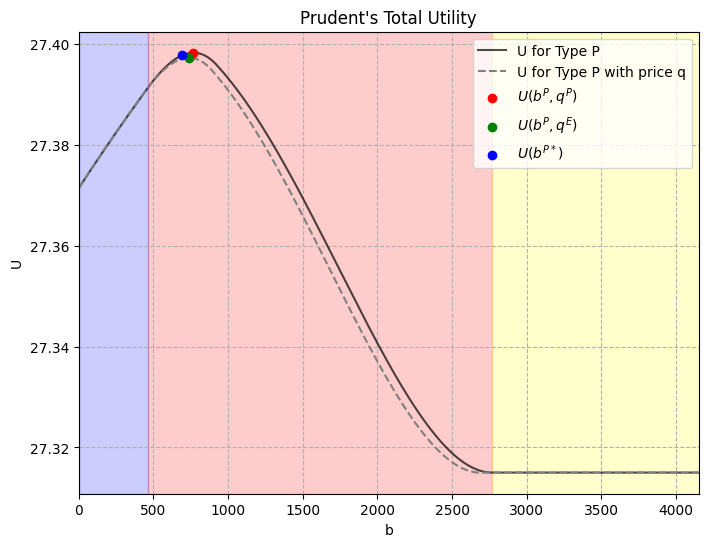

In [ ]:
max_index_uniform_p_with_price_q = np.argmax(U_values_uniform_p_with_price_q)
max_b_uniform_p_with_price_q = b_values[max_index_uniform_p_with_price_q]

plt.figure(figsize=(8, 6))
plt.plot(b_values, U_values_uniform_p, label='U for Type P', alpha=0.7, color='black')
plt.plot(b_values, U_values_uniform_p_with_price_q, label='U for Type P with price q', linestyle='--', alpha=1, color='gray')
plt.title('Prudent\'s Total Utility')
plt.xlabel('b')
plt.ylabel('U')
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.xlim(0, 1.5 * b_upper_p)
plt.grid(True, linestyle='--')
plt.scatter(max_b_uniform_p, U_values_uniform_p[max_index_uniform_p], color='red', zorder=2, label='$U(b^P,q^P)$')
plt.axvspan(0, b_lower_p, color='blue', alpha=0.2)
plt.axvspan(b_lower_p, b_upper_p, color='red', alpha=0.2)
plt.axvspan(b_upper_p, 1.5 * b_upper_p, color='yellow', alpha=0.2)

min_value_index = np.argmin(np.abs(b_values - overall_min_value))
U_at_min_value = U_values_uniform_p[min_value_index]
plt.scatter(max_b_uniform_p_with_price_q, U_values_uniform_p_with_price_q[max_index_uniform_p_with_price_q], color='green', zorder=2, label='$U(b^P,q^E)$')
plt.scatter(overall_min_value, U_at_min_value, color='blue', zorder=3, label='$U(b^{P*})$')
plt.legend()
plt.show()

In [ ]:
if U_at_min_value > U_values_uniform_p_with_price_q[max_index_uniform_p_with_price_q]:
    print("Prudent government doesn't want to deviate from b_P*")
else:
    print("Prudent government is happy that the market misunderstands him with Extravagant and he is happy that the market applies q_E to him")

Prudent government doesn't want to deviate from b_P*


# Summary of results

In [ ]:
print("Distribution choice:", distribution_choice)
print("beta_e =", beta_e)
print("beta_p =", beta_p)
print("gamma =", gamma)
print("R =", R)
print("y_lower =", y_lower)
print("y_upper =", y_upper)
print("y_3 =", y_3)
print("y_1 =", y_1)
print("y_mode (triangular) =", y_mode)
print("y_mean (normal) =", y_mean)
print("sigma (normal) =", sigma)
print("-----------------------------------------------------------------------------")
print(f"debt level where default starts for P type = {b_lower_p:.1f}")
print(f"debt level with always default for P type = {b_upper_p:.1f}")
print("b_P:", f"{max_b_uniform_p:.1f}")
if max_b_uniform_p > 1.01 * b_lower_p:
    print("b_P in red area")
else:
    print("b_P in blue area")
print("-----------------------------------------------------------------------------")
print(f"debt level where default starts for E type = {b_lower_e:.1f}")
print(f"debt level with always default for E type = {b_upper_e:.1f}")
print("b_E:", f"{max_b_uniform_e:.1f}")
if max_b_uniform_e > 1.01 * b_lower_e:
    print("b_E in red area")
else:
    print("b_E in blue area")
print("-----------------------------------------------------------------------------")
print('b_hat_e:')
for b_val in grouped_b_values:
    print(f"{b_val:.1f}")
print("b_P*:", f"{overall_min_value:.1f}")
print("-----------------------------------------------------------------------------")
print("Checking whether U^P(b_P*_lower) > U^P(b_P*_upper):")
if U_at_min_value2 > U_at_max_value:
    print("Prudent government prefers lower b_P*")
else:
    print("Prudent government prefers upper b_P*")
print("-----------------------------------------------------------------------------")
print("Calculating U_P(q_E), Checking whether Prudent government deviates from b_P*:")
if U_at_min_value > U_values_uniform_p_with_price_q[max_index_uniform_p_with_price_q]:
    print("Prudent government doesn't deviate from b_P*")
else:
    print("Prudent government is happy that the market misunderstands him with Extravagant and the market applies q_E")

Distribution choice: triangular
beta_e = 0.9
beta_p = 0.95
gamma = 0.97
R = 1
y_lower = 8000
y_upper = 48000
y_3 = 13000
y_1 = 11000
y_mode (triangular) = 15900
y_mean (normal) = 13000
sigma (normal) = 1000.0
-----------------------------------------------------------------------------
debt level where default starts for P type = 461.3
debt level with always default for P type = 2768.0
b_P: 765.5
b_P in red area
-----------------------------------------------------------------------------
debt level where default starts for E type = 449.8
debt level with always default for E type = 2699.0
b_E: 762.7
b_E in red area
-----------------------------------------------------------------------------
b_hat_e:
689.6
868.1
b_P*: 689.6
-----------------------------------------------------------------------------
Checking whether U^P(b_P*_lower) > U^P(b_P*_upper):
Prudent government prefers lower b_P*
-----------------------------------------------------------------------------
Calculating U_P(q_E)